In [1]:
%pip install numpy matplotlib mne scikit-learn tensorflow seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers


import seaborn as sns
import os


np.random.seed(42)
tf.random.set_seed(42)

mne.set_log_level('WARNING')



In [5]:
import os
import numpy as np
import mne
from tensorflow.keras.utils import to_categorical

def load_dataset(data_dir, n_classes=4):
    exclude = [88, 92, 100, 104]
    subjects = [s for s in range(1, 110) if s not in exclude]
    X, y, groups = [], [], []

    print(f"Chargement de {len(subjects)} sujets (Mode {n_classes} classes)...")

    for sub_id in subjects:
        try:
            sub_x, sub_y = [], []
            sub_str = f"S{sub_id:03d}"
            
            # --- 0. REPOS (Run 1) ---
            if n_classes >= 3:
                path_rest = os.path.join(data_dir, sub_str, f"{sub_str}R01.edf")
                if os.path.exists(path_rest):
                    raw = mne.io.read_raw_edf(path_rest, preload=True, verbose=False)
                    # 21 essais
                    epochs = mne.make_fixed_length_epochs(
                        raw, duration=3.0, overlap=0.5, preload=True, verbose=False
                    )
                    data = epochs.get_data(verbose=False)[:, :64, :480]
                    n_keep = min(len(data), 21)
                    sub_x.append(data[:n_keep])
                    sub_y.append(np.zeros(n_keep)) # Label 0

            # --- 1 & 2. GAUCHE / DROITE (Runs 4, 8, 12) ---
            raws_lr = [mne.io.read_raw_edf(os.path.join(data_dir, sub_str, f"{sub_str}R{r:02d}.edf"), 
                       preload=True, verbose=False) for r in [4, 8, 12]]
            raw_lr = mne.concatenate_raws(raws_lr)
            events, event_id = mne.events_from_annotations(raw_lr, verbose=False)
            
            
            # Si 2 classes : Gauche=0, Droite=1
            # Si 4 classes : Gauche=1, Droite=2
            t1_label = 0 if n_classes == 2 else 1
            t2_label = 1 if n_classes == 2 else 2

            for target, label in [('T1', t1_label), ('T2', t2_label)]:
                evs = np.array([e for e in events if e[2] == event_id[target]])
                epochs = mne.Epochs(raw_lr, evs, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                data = epochs.get_data(verbose=False)[:, :64, :480]
                n_keep = min(len(data), 21)
                sub_x.append(data[:n_keep])
                sub_y.append(np.full(n_keep, label))

            # --- 3. PIEDS (Runs 6, 10, 14) ---
            if n_classes == 4:
                raws_f = [mne.io.read_raw_edf(os.path.join(data_dir, sub_str, f"{sub_str}R{r:02d}.edf"), 
                          preload=True, verbose=False) for r in [6, 10, 14]]
                raw_f = mne.concatenate_raws(raws_f)
                evs_f, id_f = mne.events_from_annotations(raw_f, verbose=False)
                evs_feet = np.array([e for e in evs_f if e[2] == id_f['T2']])
                epochs_f = mne.Epochs(raw_f, evs_feet, tmin=0, tmax=3.0, baseline=None, preload=True, verbose=False)
                data = epochs_f.get_data(verbose=False)[:, :64, :480]
                n_keep = min(len(data), 21)
                sub_x.append(data[:n_keep])
                sub_y.append(np.full(n_keep, 3)) # Label 3

            # Concaténation sujet
            if sub_x:
                X_sub = np.concatenate(sub_x)
                y_sub = np.concatenate(sub_y)
                
                # Vérification dimensionnelle
                if len(X_sub) == len(y_sub):
                    X.append(X_sub.transpose(0, 2, 1))
                    y.append(y_sub)
                    groups.append(np.full(len(y_sub), sub_id))

        except Exception as e: 
            continue

    X = np.concatenate(X)[..., np.newaxis]
    y = to_categorical(np.concatenate(y), num_classes=n_classes)
    groups = np.concatenate(groups)
    
    print(f" Terminé : X={X.shape}, y={y.shape}.")
    return X, y, groups

In [6]:
# chargement de donnees
X, y, groups = load_dataset('/kaggle/input/physionet/files', n_classes=2)

Chargement de 105 sujets (Mode 2 classes)...
 Terminé : X=(4410, 480, 64, 1), y=(4410, 2).


In [7]:

import tensorflow as tf
from tensorflow.keras import models, layers

def build_model(n_classes=4, n_channels=64, n_times=480):
    
    model = models.Sequential([
      
        layers.Input(shape=(n_times, n_channels, 1)),
        
        # 1. Convolution Temporelle
        layers.Conv2D(filters=40, kernel_size=(30, 1), padding='same', name='temporal_conv'),

        # 2. Convolution Spatiale 
        layers.Conv2D(filters=40, kernel_size=(1, n_channels), padding='valid', name='spatial_conv'),

        # 3. Pooling Temporel  
        layers.AveragePooling2D(pool_size=(15, 1), padding='valid', name='avg_pool'),

        layers.Flatten(name='flatten'),

        # 4. Fully Connected 
        layers.Dense(80, name='fc_80'),

        # 5. Output Layer : Softmax 
        layers.Dense(n_classes, activation='softmax', name='softmax_output')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model


model = build_model(n_classes=2, n_channels=64, n_times=480)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ temporal_conv (Conv2D)          │ (None, 480, 64, 40)    │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_conv (Conv2D)           │ (None, 480, 1, 40)     │       102,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool (AveragePooling2D)     │ (None, 32, 1, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_80 (Dense)                   │ (None, 80)             │       102,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 2)              │           162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,322 (805.95 KB)

 Trainable params: 206,322 (805.95 KB)

 Non-trainable params: 0 (0.00 B)

PHASE 1 : ENTRAÎNEMENT GLOBAL (4 CLASSES)

--- FOLD 1/5 ---
Epoch 1/50


I0000 00:00:1768076929.547616      92 service.cc:152] XLA service 0x7f7cc0014640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768076929.547656      92 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768076929.817302      92 cuda_dnn.cc:529] Loaded cuDNN version 91002


 24/441 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2466 - loss: 1.3949

I0000 00:00:1768076932.122929      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2430 - loss: 1.3933 - val_accuracy: 0.2500 - val_loss: 1.3884
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2518 - loss: 1.3864 - val_accuracy: 0.4087 - val_loss: 1.2820
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4494 - loss: 1.2048 - val_accuracy: 0.5385 - val_loss: 1.1561
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5280 - loss: 1.1119 - val_accuracy: 0.5618 - val_loss: 1.1519
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5613 - loss: 1.0737 - val_accuracy: 0.5618 - val_loss: 1.1313
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5852 - loss: 1.0380 - val_accuracy: 0.5765 - val_loss: 1.1263
Epoch 7/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5970 - loss: 1.0102 - val_accuracy: 0.5828 - val_loss: 1.1173
Epoch 8/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6076 - loss: 0.9913 - val_accuracy: 0.5726 - val

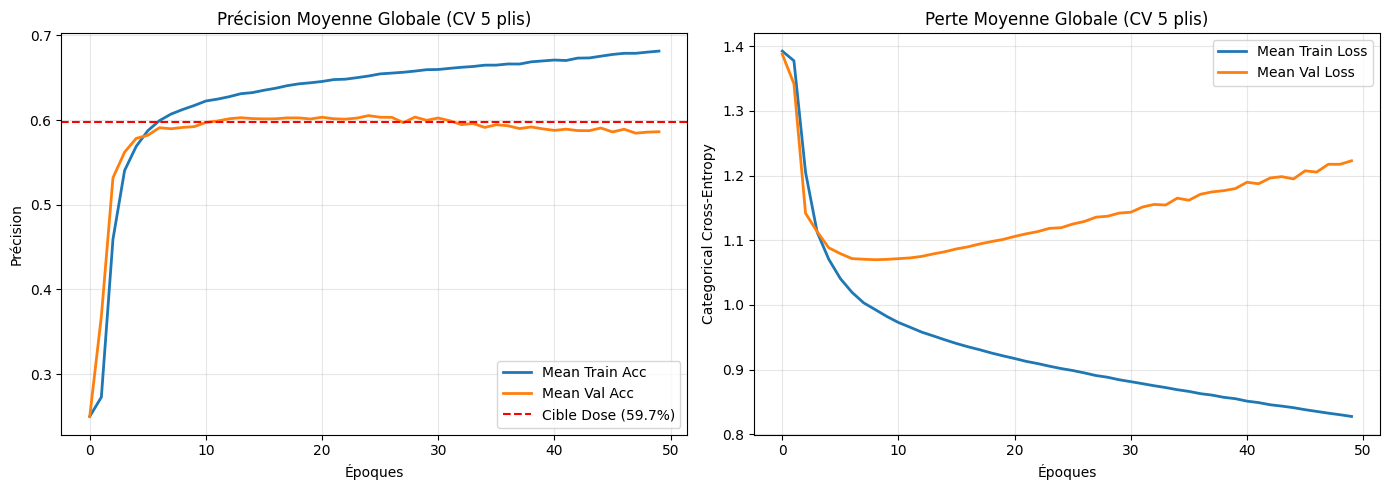

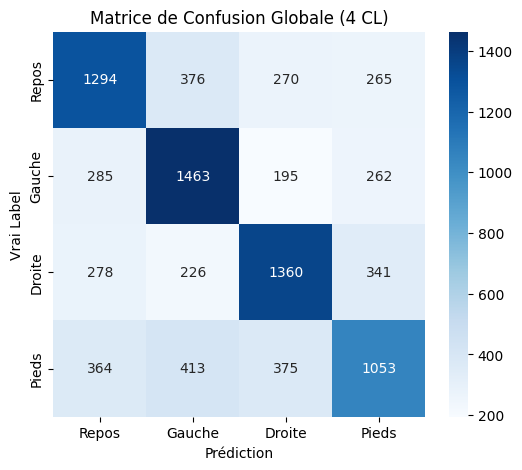


PRÉCISION GLOBALE MOYENNE FINALE : 58.62%


In [27]:
#4 classes
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix

# --- CONFIGURATION 
N_CLASSES = y.shape[1] 
target = 0.8010 if N_CLASSES == 2 else 0.5971 
WEIGHTS_PATH = f'global_{N_CLASSES}cl.weights.h5'
BATCH_SIZE = 16  
EPOCHS = 50      
N_SPLITS = 5    

print(f"{'='*60}")
print(f"PHASE 1 : ENTRAÎNEMENT GLOBAL ({N_CLASSES} CLASSES)")
print(f"{'='*60}")


history_all_folds = {
    'accuracy': [], 'val_accuracy': [],
    'loss': [], 'val_loss': []
}

gkf = GroupKFold(n_splits=N_SPLITS)
fold_accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    print(f"\n--- FOLD {fold}/{N_SPLITS} ---")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Construction du modèle 
    model = build_dose_model(n_classes=N_CLASSES, n_channels=64, n_times=480)
    
    # Entraînement 
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test),
        verbose=1
    )
    
    # Sauvegarde des métriques de ce pli
    for key in history_all_folds.keys():
        history_all_folds[key].append(history.history[key])

    # Évaluation
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(acc)
    print(f" Précision du Fold {fold}: {acc:.2%}")
    

    if fold == 1 or acc > max(fold_accuracies[:-1]):
        model.save_weights(WEIGHTS_PATH)
        print(f" Nouveau record ! Poids sauvegardés : {WEIGHTS_PATH}")

    # Prédictions pour la matrice de confusion globale
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    all_y_pred.extend(y_pred)
    all_y_true.extend(np.argmax(y_test, axis=1))

# --- CALCUL DES MOYENNES GLOBALES PAR ÉPOQUE ---
mean_metrics = {key: np.mean(history_all_folds[key], axis=0) for key in history_all_folds.keys()}

# --- VISUALISATION GLOBALE ---
plt.figure(figsize=(14, 5))

# Précision Moyenne Globale
plt.subplot(1, 2, 1)
plt.plot(mean_metrics['accuracy'], label='Mean Train Acc', color='#1f77b4', linewidth=2)
plt.plot(mean_metrics['val_accuracy'], label='Mean Val Acc', color='#ff7f0e', linewidth=2)
plt.axhline(y=target, color='r', linestyle='--', label=f'Cible Dose ({target:.1%})')
plt.title(f'Précision Moyenne Globale (CV {N_SPLITS} plis)')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True, alpha=0.3)

#  Perte Moyenne Globale
plt.subplot(1, 2, 2)
plt.plot(mean_metrics['loss'], label='Mean Train Loss', color='#1f77b4', linewidth=2)
plt.plot(mean_metrics['val_loss'], label='Mean Val Loss', color='#ff7f0e', linewidth=2)
plt.title(f'Perte Moyenne Globale (CV {N_SPLITS} plis)')
plt.xlabel('Époques')
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matrice de Confusion Globale
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(6, 5))
labels = ['Gauche', 'Droite'] if N_CLASSES == 2 else ['Repos', 'Gauche', 'Droite', 'Pieds']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Matrice de Confusion Globale ({N_CLASSES} CL)')
plt.ylabel('Vrai Label')
plt.xlabel('Prédiction')
plt.show()

print(f"\nPRÉCISION GLOBALE MOYENNE FINALE : {np.mean(fold_accuracies):.2%}")

Démarrage Phase 1 (2 classes)...
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5165 - loss: 0.6968 - val_accuracy: 0.5023 - val_loss: 0.6929
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5536 - loss: 0.6806 - val_accuracy: 0.8197 - val_loss: 0.4714
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7916 - loss: 0.4482 - val_accuracy: 0.8243 - val_loss: 0.4546
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8016 - loss: 0.4105 - val_accuracy: 0.8288 - val_loss: 0.4557
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8109 - loss: 0.4023 - val_accuracy: 0.8356 - val_loss: 0.4598
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8199 - loss: 0.3988 - val_accuracy: 0.8333 - val_loss: 0.4643
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8206 - loss: 0.3983 - val_accuracy: 0.8299 - val_loss: 0.4745
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8252

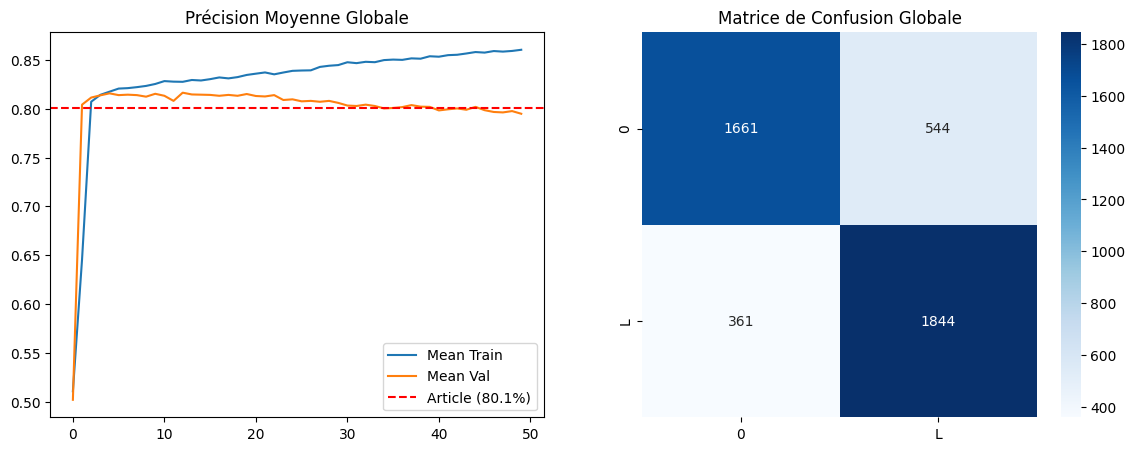

PRÉCISION FINALE : 79.48%


In [38]:
# 2 classes
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


N_CLASSES = y.shape[1]
WEIGHTS_PATH = f'global_{N_CLASSES}cl.weights.h5'
TARGET_ACC = 0.8010 if N_CLASSES == 2 else 0.5971 

all_histories = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
gkf = GroupKFold(n_splits=5)
fold_accuracies, all_y_true, all_y_pred = [], [], []

print(f"Démarrage Phase 1 ({N_CLASSES} classes)...")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = build_dose_model(n_classes=N_CLASSES)
    # Batch size 16 
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, 
                        validation_data=(X_test, y_test), verbose=1)
    
    for key in all_histories: all_histories[key].append(history.history[key])
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(acc)
    
    if fold == 1 or acc > max(fold_accuracies[:-1]): model.save_weights(WEIGHTS_PATH)
    
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    all_y_pred.extend(y_pred); all_y_true.extend(np.argmax(y_test, axis=1))

# --- GRAPHES GLOBAUX ---
mean_metrics = {k: np.mean(all_histories[k], axis=0) for k in all_histories}
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_metrics['accuracy'], label='Mean Train')
plt.plot(mean_metrics['val_accuracy'], label='Mean Val')
plt.axhline(y=TARGET_ACC, color='r', linestyle='--', label=f'Article ({TARGET_ACC:.1%})')
plt.title('Précision Moyenne Globale'); plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0','L','R','F'][:N_CLASSES], yticklabels=['0','L','R','F'][:N_CLASSES])
plt.title('Matrice de Confusion Globale'); plt.show()

print(f"PRÉCISION FINALE : {np.mean(fold_accuracies):.2%}")

In [7]:
from sklearn.model_selection import KFold
import numpy as np
import os

# --- CONFIGURATION  ---
N_CLASSES = 2  
WEIGHTS_FILENAME = f'global_{N_CLASSES}cl.weights.h5'

print(f"{'='*60}")
print(f"PHASE 2 : ADAPTATION SPÉCIFIQUE ({N_CLASSES} CLASSES)")
print(f"Chargement des poids : {WEIGHTS_FILENAME}")
print(f"{'='*60}")

if not os.path.exists(WEIGHTS_FILENAME):
    print(f" Erreur : Le fichier {WEIGHTS_FILENAME} est introuvable.")
else:
    unique_subjects = np.unique(groups)
    all_subject_accuracies = []

 
    RETRAIN_EPOCHS = 5       
    N_SUB_FOLDS = 4       
    SS_BATCH_SIZE = 16      

    for sub_id in unique_subjects:
        # 1. Extraction des données du sujet 
        sub_mask = (groups == sub_id)
        X_sub = X[sub_mask]
        y_sub = y[sub_mask]
        
        # 2. Split 75% train / 25% évaluation via 4-folds 
        kf = KFold(n_splits=N_SUB_FOLDS, shuffle=True, random_state=42)
        sub_fold_accs = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_sub), 1):
            X_train_ss, X_test_ss = X_sub[train_idx], X_sub[test_idx]
            y_train_ss, y_test_ss = y_sub[train_idx], y_sub[test_idx]
            
            # 3. Recréer le modèle avec le bon nombre de classes
            ss_model = build_dose_model(n_classes=N_CLASSES, n_channels=64, n_times=480)
            
            # Charger les poids du modèle global correspondant 
            ss_model.load_weights(WEIGHTS_FILENAME) 
            
            # 4. Retraining de 5 époques 
            ss_model.fit(
                X_train_ss, y_train_ss,
                epochs=RETRAIN_EPOCHS,
                batch_size=SS_BATCH_SIZE,
                verbose=0 
            )
            
            # 5. Évaluation 
            _, acc = ss_model.evaluate(X_test_ss, y_test_ss, verbose=0)
            sub_fold_accs.append(acc)
            
        all_subject_accuracies.append(np.mean(sub_fold_accs))
        
        if len(all_subject_accuracies) % 10 == 0:
            print(f"Sujets traités : {len(all_subject_accuracies)}/{len(unique_subjects)} | Moyenne : {np.mean(all_subject_accuracies):.2%}")

    # --- BILAN FINAL ---
    final_avg = np.mean(all_subject_accuracies)
    print(f"\n{'='*60}")
    print(f"RÉSULTATS FINAUX ({N_CLASSES} CLASSES) :")
    print(f"Précision Subject-Specific : {final_avg:.2%}")
    

    target = 0.8613 if N_CLASSES == 2 else 0.6893
    print(f"{'='*60}")

PHASE 2 : ADAPTATION SPÉCIFIQUE (2 CLASSES)
Chargement des poids : global_2cl.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Sujets traités : 10/105 | Moyenne : 86.16%
Sujets traités : 20/105 | Moyenne : 85.19%
Sujets traités : 30/105 | Moyenne : 82.77%
Sujets traités : 40/105 | Moyenne : 83.43%
Sujets traités : 50/105 | Moyenne : 83.77%
Sujets traités : 60/105 | Moyenne : 84.61%
Sujets traités : 70/105 | Moyenne : 84.47%
Sujets traités : 80/105 | Moyenne : 84.29%
Sujets traités : 90/105 | Moyenne : 84.49%
Sujets traités : 100/105 | Moyenne : 84.62%

RÉSULTATS FINAUX (2 CLASSES) :
Précision Subject-Specific : 84.63%


In [45]:
from sklearn.model_selection import KFold
import numpy as np
import os

# --- CONFIGURATION  ---
N_CLASSES = 4
WEIGHTS_FILENAME = f'global_{N_CLASSES}cl.weights.h5'

print(f"{'='*60}")
print(f"PHASE 2 : ADAPTATION SPÉCIFIQUE ({N_CLASSES} CLASSES)")
print(f"Chargement des poids : {WEIGHTS_FILENAME}")
print(f"{'='*60}")

if not os.path.exists(WEIGHTS_FILENAME):
    print(f"❌ Erreur : Le fichier {WEIGHTS_FILENAME} est introuvable.")
else:
    unique_subjects = np.unique(groups)
    all_subject_accuracies = []


    RETRAIN_EPOCHS = 5     
    N_SUB_FOLDS = 4        
    SS_BATCH_SIZE = 16    

    for sub_id in unique_subjects:
        # 1. Extraction des données du sujet 
        sub_mask = (groups == sub_id)
        X_sub = X[sub_mask]
        y_sub = y[sub_mask]
        
        # 2. Split 75% train / 25% évaluation via 4-folds 
        kf = KFold(n_splits=N_SUB_FOLDS, shuffle=True, random_state=42)
        sub_fold_accs = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X_sub), 1):
            X_train_ss, X_test_ss = X_sub[train_idx], X_sub[test_idx]
            y_train_ss, y_test_ss = y_sub[train_idx], y_sub[test_idx]
            
            # 3. Recréer le modèle avec le bon nombre de classes
            ss_model = build_dose_model(n_classes=N_CLASSES, n_channels=64, n_times=480)
            
            # Charger les poids du modèle global correspondant 
            ss_model.load_weights(WEIGHTS_FILENAME) 
            
            # 4. Retraining de 5 époques 
            ss_model.fit(
                X_train_ss, y_train_ss,
                epochs=RETRAIN_EPOCHS,
                batch_size=SS_BATCH_SIZE,
                verbose=0 
            )
            
            # 5. Évaluation 
            _, acc = ss_model.evaluate(X_test_ss, y_test_ss, verbose=0)
            sub_fold_accs.append(acc)
            
        all_subject_accuracies.append(np.mean(sub_fold_accs))
        
        if len(all_subject_accuracies) % 10 == 0:
            print(f"Sujets traités : {len(all_subject_accuracies)}/{len(unique_subjects)} | Moyenne : {np.mean(all_subject_accuracies):.2%}")

    # --- BILAN FINAL ---
    final_avg = np.mean(all_subject_accuracies)
    print(f"\n{'='*60}")
    print(f"RÉSULTATS FINAUX ({N_CLASSES} CLASSES) :")
    print(f"Précision Subject-Specific : {final_avg:.2%}")
    
 
    target = 0.8613 if N_CLASSES == 2 else 0.6893
    print(f"{'='*60}")

PHASE 2 : ADAPTATION SPÉCIFIQUE (4 CLASSES)
Chargement des poids : global_4cl.weights.h5


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Sujets traités : 10/105 | Moyenne : 75.00%
Sujets traités : 20/105 | Moyenne : 72.20%
Sujets traités : 30/105 | Moyenne : 69.44%
Sujets traités : 40/105 | Moyenne : 69.97%
Sujets traités : 50/105 | Moyenne : 70.48%
Sujets traités : 60/105 | Moyenne : 70.91%
Sujets traités : 70/105 | Moyenne : 70.90%
Sujets traités : 80/105 | Moyenne : 70.25%
Sujets traités : 90/105 | Moyenne : 70.30%
Sujets traités : 100/105 | Moyenne : 70.56%

RÉSULTATS FINAUX (4 CLASSES) :
Précision Subject-Specific : 70.31%


In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf


model = model = build_model(n_classes=2, n_channels=64, n_times=480)

model.load_weights('global_2cl.weights.h5')

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


y_true = np.argmax(y_test, axis=1)


target_names = ['Left Hand', 'Right Hand']
report = classification_report(y_true, y_pred, target_names=target_names)

print("Classification Report for Global Model (Binary):")
print(report)


print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1768096010.916014      94 service.cc:152] XLA service 0x7e34280263d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768096010.916056      94 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768096011.023685      94 cuda_dnn.cc:529] Loaded cuDNN version 91002


25/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1768096012.401804      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Classification Report for Global Model (Binary):
              precision    recall  f1-score   support

   Left Hand       0.88      0.83      0.85       441
  Right Hand       0.84      0.88      0.86       441

    accuracy                           0.86       882
   macro avg       0.86      0.86      0.86       882
weighted avg       0.86      0.86      0.86       882

Confusion Matrix:
[[365  76]
 [ 51 390]]
